In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [2]:
data = pd.read_csv('/kaggle/input/cidaut-ai-fake-scene-classification-2024/train.csv', header=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   720 non-null    object
 1   label   720 non-null    object
dtypes: object(2)
memory usage: 11.4+ KB


## Split

In [3]:
from sklearn.model_selection import train_test_split

# Dividir en entrenamiento (80%) y prueba (20%)
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Dividir en entrenamiento (70%) y validación (10%)
train_data, val_data = train_test_split(train_val_data, test_size=0.125, random_state=42)

print('train data: ', train_data.shape)
print('test data: ', test_data.shape)
print('validation data: ', val_data.shape)

train data:  (504, 2)
test data:  (144, 2)
validation data:  (72, 2)


## Aumentaciones

In [4]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Redimensionar a 512x512
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ColorJitter(saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización estándar
])

# Transformaciones para validación y prueba
val_test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Redimensionar a 512x512
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [5]:
from torch.utils.data import Dataset, DataLoader

# Clase para almacenar el dataset con las etiquetas correctas
class CustomImageDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]  # Nombre de la imagen
        img_path = os.path.join(self.img_dir, img_name)  # Ruta completa de la imagen

        # Verificar si la imagen existe
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Imagen '{img_path}' no encontrada.")

        # Cargar imagen y etiqueta
        image = Image.open(img_path).convert("RGB")
        label_str = self.annotations.iloc[idx, 1]

        # Cambiar etiqueta a entero
        label = 1 if label_str == 'real' else 0

        if self.transform:
            image = self.transform(image)

        return image, label

## Dataloaders

In [6]:
# Crear los conjuntos de datos
train_dataset = CustomImageDataset(annotations=train_data, img_dir='/kaggle/input/cidaut-ai-fake-scene-classification-2024/Train', transform=transform)
val_dataset = CustomImageDataset(annotations=val_data, img_dir='/kaggle/input/cidaut-ai-fake-scene-classification-2024/Train', transform=val_test_transform)
test_dataset = CustomImageDataset(annotations=test_data, img_dir='/kaggle/input/cidaut-ai-fake-scene-classification-2024/Train', transform=val_test_transform)

# Crear los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modelo

In [7]:
# # Modelo 1 y 2
# # Cargar el modelo EfficientNet-B2 preentrenado
# model = models.efficientnet_b2(pretrained=True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # Ajustar salida a 2 clases (real/IA)
# model = model.to(device)

# #Modelo 3
# # Cargar el modelo preentrenado y ajustar la capa de salida
# model = models.efficientnet_b0(pretrained=True)
# num_features = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(num_features, 2)  # Dos clases: real e IA
# model = model.to(device)

In [8]:
# Modelo Final
# Clase personalizada para EfficientNet con Dropout
class CustomEfficientNet(nn.Module):
    def __init__(self):
        super(CustomEfficientNet, self).__init__()
        # Cargar EfficientNet-B0 preentrenado
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, 128)

        # Capas adicionales
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout después de la primera capa
        self.fc2 = nn.Linear(128, 2)        # Capa de salida
        self.dropout2 = nn.Dropout(p=0.3)   # Dropout antes de la capa de salida

    def forward(self, x):
        x = self.efficientnet(x)  # Pasar por EfficientNet
        x = self.dropout1(x)      # Aplicar Dropout
        x = self.fc2(x)           # Capa intermedia
        x = self.dropout2(x)      # Aplicar Dropout antes de la salida
        return x

# Instanciar el modelo
model = CustomEfficientNet()
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 113MB/s] 


In [9]:
# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Entrenamiento

Epoch [1/100], Train Loss: 0.6706, Train Accuracy: 59.33%, Val Loss: 0.6568, Val Accuracy: 63.89%
Epoch [2/100], Train Loss: 0.5776, Train Accuracy: 75.00%, Val Loss: 0.4526, Val Accuracy: 87.50%
Epoch [3/100], Train Loss: 0.3537, Train Accuracy: 89.29%, Val Loss: 0.1277, Val Accuracy: 98.61%
Epoch [4/100], Train Loss: 0.1889, Train Accuracy: 91.67%, Val Loss: 0.1491, Val Accuracy: 93.06%
Epoch [5/100], Train Loss: 0.1225, Train Accuracy: 93.85%, Val Loss: 0.0229, Val Accuracy: 98.61%
Epoch [6/100], Train Loss: 0.1223, Train Accuracy: 93.85%, Val Loss: 0.0196, Val Accuracy: 100.00%
Epoch [7/100], Train Loss: 0.1060, Train Accuracy: 94.05%, Val Loss: 0.0178, Val Accuracy: 100.00%
Epoch [8/100], Train Loss: 0.1504, Train Accuracy: 92.26%, Val Loss: 0.0459, Val Accuracy: 98.61%
Epoch [9/100], Train Loss: 0.1297, Train Accuracy: 93.85%, Val Loss: 0.0090, Val Accuracy: 100.00%
Epoch [10/100], Train Loss: 0.1083, Train Accuracy: 92.06%, Val Loss: 0.0072, Val Accuracy: 100.00%
Epoch [11/100],

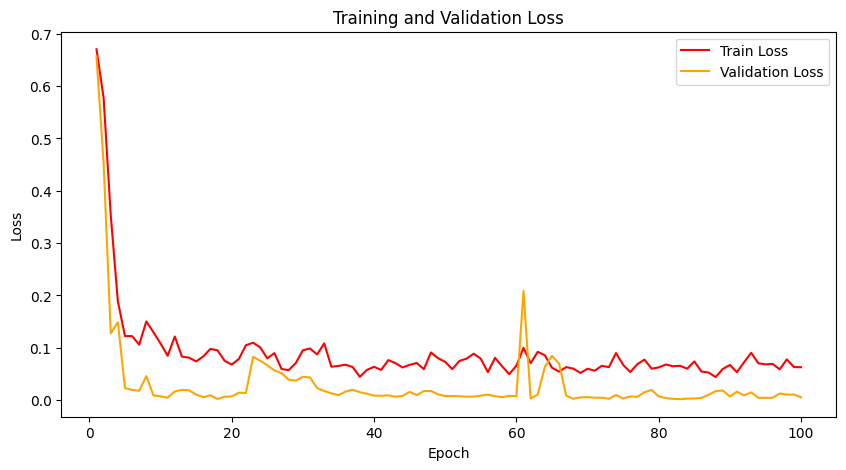

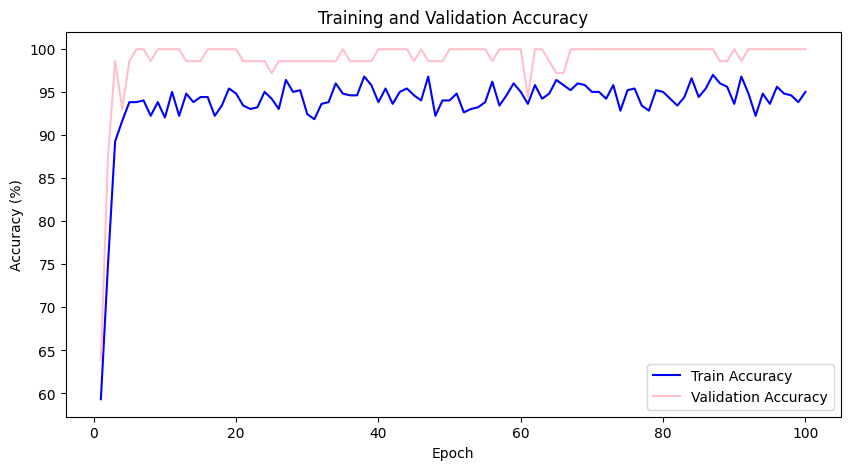

In [10]:
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Modo de entrenamiento
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Modo de evaluación para validación
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Desactivar gradientes en validación
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Cálculo de las métricas
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = 100 * correct_train / total_train
        val_accuracy = 100 * correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    # Graficar loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Graficar accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='pink')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Función de entrenamiento y validación
train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)


# Evaluación

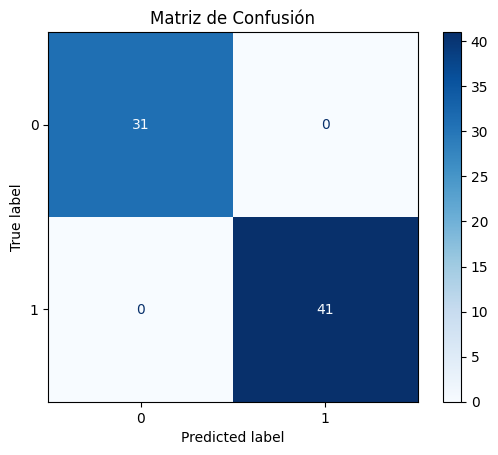

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, val_loader, device):
    # Modo de evaluación
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Convertir a arreglos de numpy
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Crear matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions)

    # Visualizar matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.show()

# Matriz de confusion val
plot_confusion_matrix(model, val_loader, device)

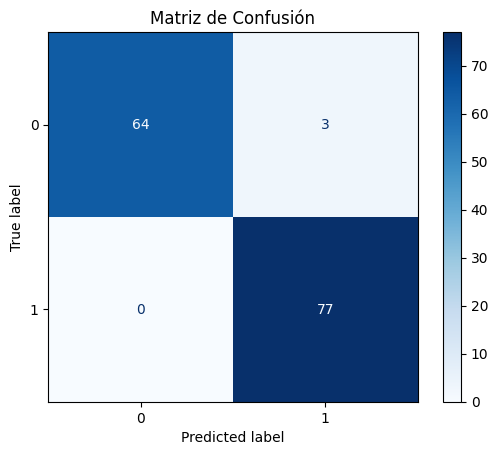

In [12]:
# Matriz de confusion test
plot_confusion_matrix(model, test_loader, device)

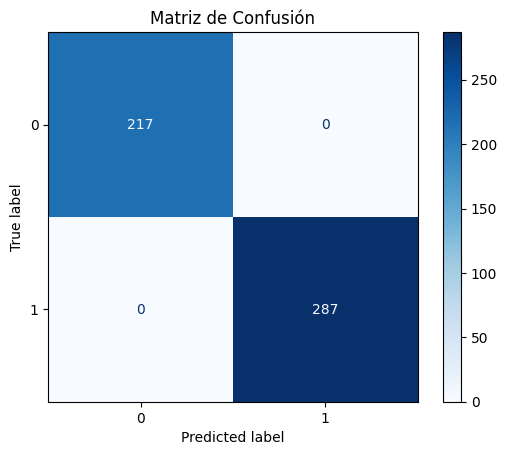

In [13]:
# Matriz de confusion train
plot_confusion_matrix(model, train_loader, device)

In [14]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Obtener la clase predicha
            _, predicted = torch.max(outputs, 1)
            
            # Guardar las etiquetas reales y predichas
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='binary')
    
    print(f'Precisión (Accuracy): {accuracy:.4f}')
    print(f'F1-score: {f1:.4f}')
    
    return accuracy, f1


In [15]:
# Evaluar el modelo con métricas
print("Métricas en Test")
accuracy, f1 = evaluate_model(model, test_loader, device)

Métricas en Test
Precisión (Accuracy): 0.9792
F1-score: 0.9809


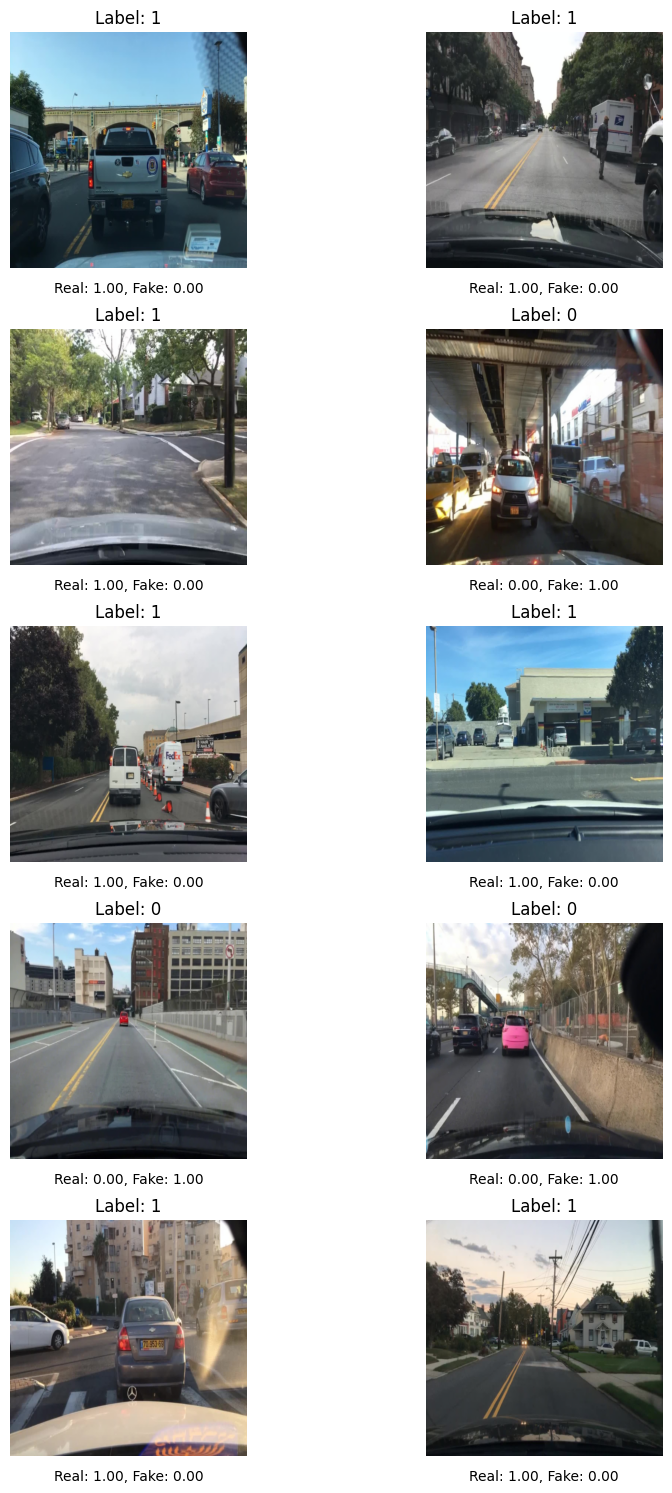

In [16]:
# Obtener 10 imágenes del conjunto de datos de test
images, labels = next(iter(test_loader))
images = images[:10].to(device)
labels = labels[:10].to(device)

# Obtener las predicciones del modelo
model.eval()
with torch.no_grad():
    outputs = model(images)

# Calcular las probabilidades
probabilities = torch.softmax(outputs, dim=1)

# Mostrar las imágenes y las probabilidades
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, (image, probability, label) in enumerate(zip(images, probabilities, labels)):
  image = image.cpu().numpy().transpose((1, 2, 0))
  image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
  image = np.clip(image, 0, 1)
  ax = axes[i // 2, i % 2]
  ax.imshow(image)
  ax.set_title(f"Label: {label.item()}")
  ax.axis('off')

  # Mostrar las probabilidades
  real_prob = probability[1].item()
  fake_prob = probability[0].item()
  ax.text(0.5, -0.1, f"Real: {real_prob:.2f}, Fake: {fake_prob:.2f}", ha='center', transform=ax.transAxes)


plt.tight_layout()
plt.show()

In [17]:
# Supongamos que `model` es tu modelo ya entrenado
PATH = "/kaggle/working/model.pt"
torch.save(model, PATH)
